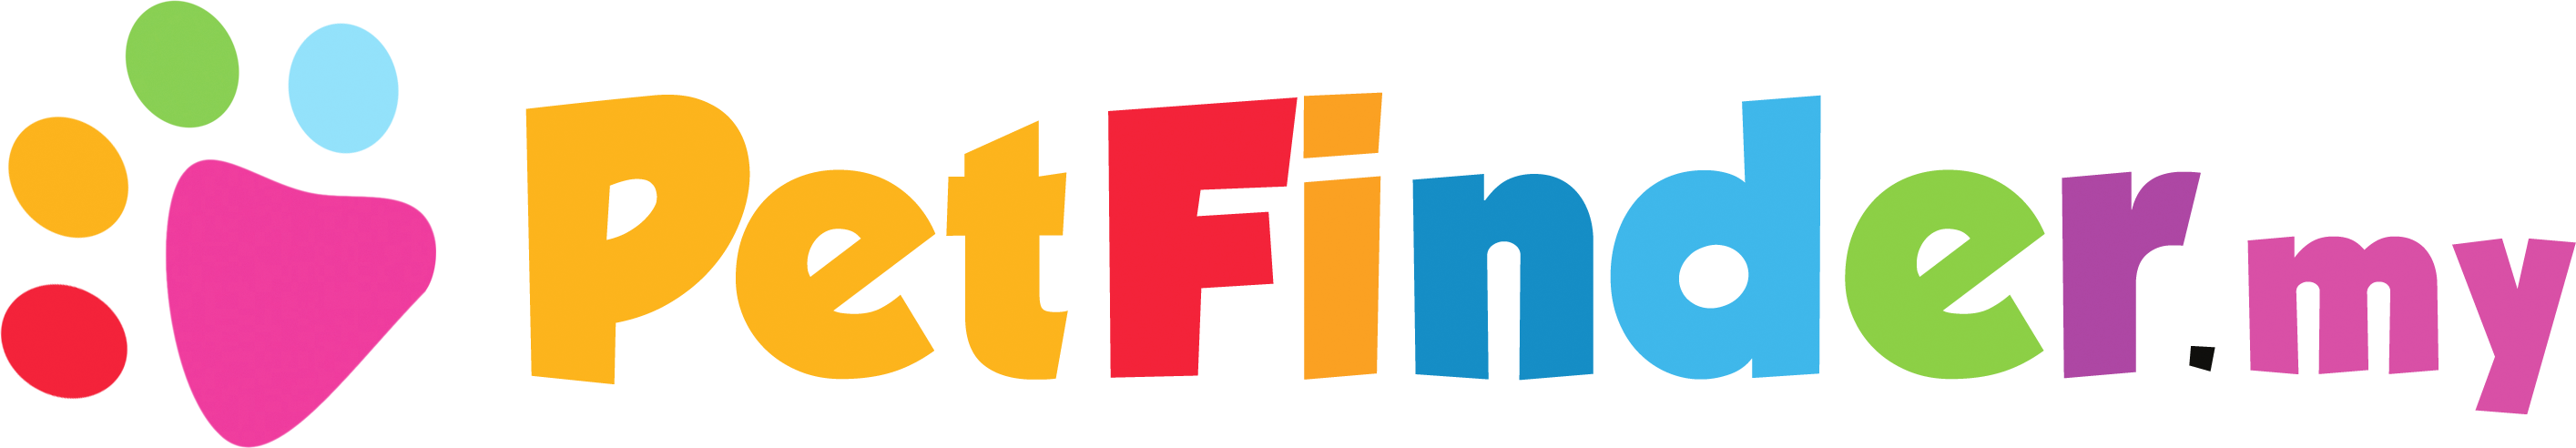

# Проект "Pet Finder"

## Описание проекта

Компания PetFinder, которая занимается защитой животных, хочет узнать, как измерить на сколько будет популярна та или иная фотография питомца.

## Описание данных

- `Focus` - Питомец выделяется на незагроможденном фоне, не слишком близко/далеко.

- `Eyes` - Оба глаза смотрят вперед или почти вперед, по крайней мере, 1 глаз/зрачок достаточно ясный.

- `Face` - Прилично чистое лицо, обращенное вперед или почти вперед.

- `Near` - один питомец занимает значительную часть фотографии (примерно более 50% ширины или высоты фотографии).

- `Action` - Питомец посреди действия (например, прыжка).

- `Accessory` - Сопровождающий физический или цифровой аксессуар/реквизит (например, игрушка, цифровая наклейка), за исключением ошейника и поводка.

- `Group` - Более 1 питомца на фото.

- `Collage` - фотография с цифровой ретушью (т.е. с цифровой фоторамкой, комбинация нескольких фотографий).

- `Human` - Человек на фото.

- `Occlusion` - Конкретные нежелательные объекты, блокирующие часть животного (например, человека, клетку или забор). Обратите внимание, что не все блокирующие объекты считаются окклюзией.

- `Info` - Пользовательский добавленный текст или метки (например, имя питомца, описание).

- `Blur` - Заметно не в фокусе или шумно, особенно для глаз и лица питомца. Для записей Blur в столбце «Глаза» всегда установлено значение 0.

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [135]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Проверим все ли данные присутствуют

In [136]:
train.isnull().sum()

Id               0
Subject Focus    0
Eyes             0
Face             0
Near             0
Action           0
Accessory        0
Group            0
Collage          0
Human            0
Occlusion        0
Info             0
Blur             0
Pawpularity      0
dtype: int64

Переименуем столбец `Subject Focus`, убрав пробел 

In [142]:
train.rename(columns={'Subject Focus': 'SubjectFocus'}, inplace=True)
test.rename(columns={'Subject Focus': 'SubjectFocus'}, inplace=True)
train.head(10)

,Id,SubjectFocus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
5,001dd4f6fafb890610b1635f967ea081,0,0,1,0,0,0,0,0,0,0,0,1,74
6,0023b8a3abc93c712edd6120867deb53,0,1,1,1,0,0,0,0,1,1,0,0,22
7,0031d6a9ef7340f898c3e05f92c7bb04,0,1,1,0,0,0,1,1,0,0,1,0,35
8,0042bc5bada6d1cf8951f8f9f0d399fa,0,1,1,1,0,0,0,0,0,0,0,0,53
9,0049cb81313c94fa007286e9039af910,0,1,1,1,0,0,0,0,0,0,0,0,21


Взглянем на пару изображений 

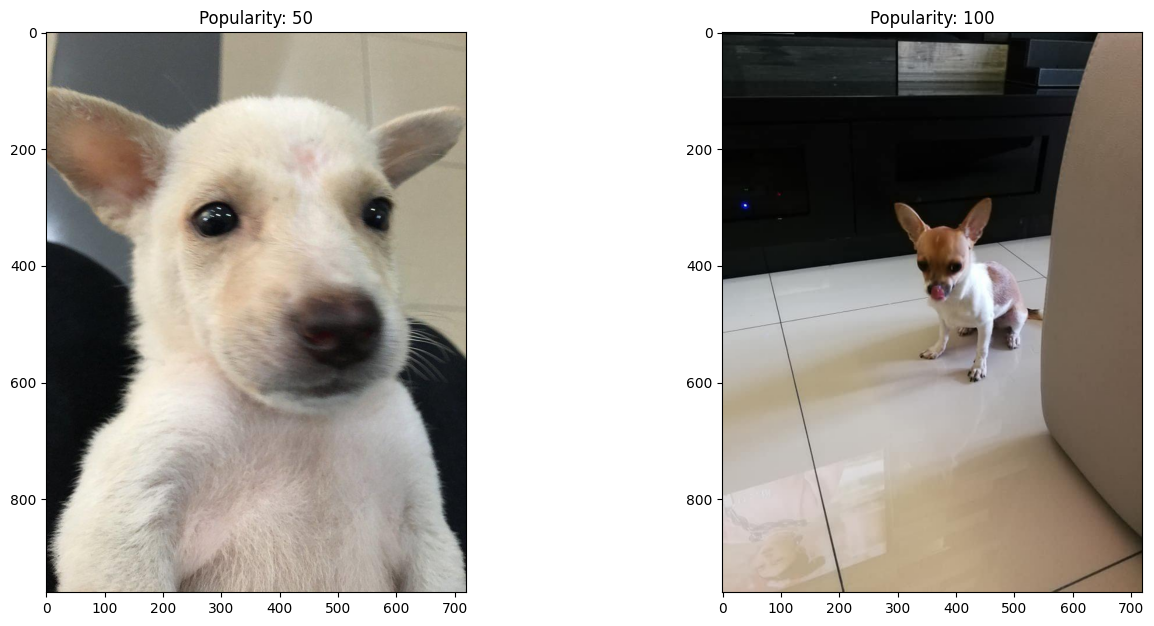

In [35]:
fig = plt.figure(figsize=(16, 16))

ax1 = fig.add_subplot(2, 2, 1)
ax1.set_title('Popularity: ' + str(train['Pawpularity'][23]))
img = plt.imread('train/' + train['Id'][23] + '.jpg')
plt.imshow(img)

ax2 = fig.add_subplot(2, 2, 2)
ax2.set_title('Popularity: ' + str(train['Pawpularity'][19]))
img = plt.imread('train/' + train['Id'][19] + '.jpg')
plt.imshow(img)

plt.show();

Чем же они так отличаются, что фотография справа является милой на 100%, а слева - всего на 50. Посмотрим на признаки каждой из фотографий

In [45]:
display(train.loc[23])
display(train.loc[19])

Id               0085bfb9a7ebfd776cb804d8b456bb05
Subject Focus                                   0
Eyes                                            1
Face                                            1
Near                                            1
Action                                          0
Accessory                                       0
Group                                           0
Collage                                         0
Human                                           0
Occlusion                                       0
Info                                            0
Blur                                            0
Pawpularity                                    50
Name: 23, dtype: object

Id               00768659c1c90409f81dcdecbd270513
Subject Focus                                   0
Eyes                                            1
Face                                            1
Near                                            0
Action                                          0
Accessory                                       0
Group                                           0
Collage                                         0
Human                                           0
Occlusion                                       0
Info                                            0
Blur                                            0
Pawpularity                                   100
Name: 19, dtype: object

Разница между фотографиями лишь в том, что у одной есть признак `Near`, отвечающий за близость животного к камере. Посмотрим действительно ли существует такая тенденция, что, при признаках `Eyes` и `Face`, признак `Near` будет иметь отрицательный вес на `Pawpularity`.

Для этого добавим новый столбец `Nfeatures`, означающий количество признаков == 1.

In [143]:
features = train.columns[1:-1]
train['Nfeatures'] = train[features].sum(axis=1)
train.head()

,Id,SubjectFocus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,Nfeatures
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,4
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,2
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,5
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,3
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,2


In [144]:
print('Средняя популярность фото, с признаками Eyes и Face:', \
      train[(train['Nfeatures'] == 2) & (train['Eyes'] == 1) & (train['Face'] == 1)]['Pawpularity'].mean())

print('Средняя популярность фото, с признаками Eyes, Face и Near:',\
      train[(train['Nfeatures'] == 3) & (train['Eyes'] == 1) & (train['Face'] == 1) & \
          (train['Near'] == 1)]['Pawpularity'].mean())

Средняя популярность фото, с признаками Eyes и Face: 37.68690095846645
Средняя популярность фото, с признаками Eyes, Face и Near: 37.96590330788804


Как видим, здесь никакой связи не наблюдается 

Посмотрим на матрицу корреляций.

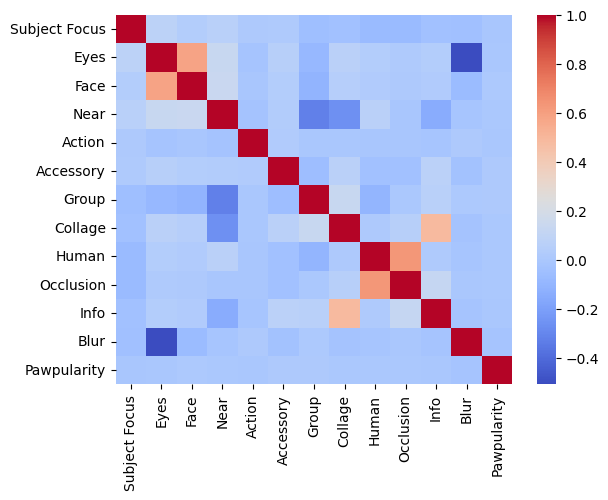

In [140]:
corr = train.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm');

Целевая функция ни с чем не коррелирует.

Признаки `Eyes` и `Blur` имеют отрицательную корреляцию, что и сказано в описании данных. 

`Face` и `Eyes` средне коррелируют со значением 0.58.

`Occlusion` и `Human`коррелируют на 0.63.

`Info` и `Collage` имеют небольшую корреляцию в 0.48, однако, это может пригодиться.

`Near` и `Group`так же отрицательно коррелируют, что достаточно понятно, так как тяжело уместить более 1 питомца близко к камере.

Добавим новый столбец `Features`, который будет хранить в себе массив нулей и единиц (все признаки, собранные в один массив) и столбец `FeaturesStr`, который будет представлять собой данный массив в одной строке (чтобы выделить уникальные комбинации), для дальнейшего анализа вклада каждой из комбинации в целевую функцию `Pawpularity`.

In [212]:
train['Features'] = pd.Series(list(train[features].values))
train['FeaturesStr'] = train['Features'].apply(lambda x: ''.join(list(map(str, x))))
train.head()

,Id,SubjectFocus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,Nfeatures,Features,FeaturesStr
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,4,"[0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]",011100100000
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,2,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",011000000000
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,5,"[0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0]",011100001100
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,3,"[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]",011100000000
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,2,"[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]",000100100000


Для каждой из таких комбинаций распечатаем значения: <b>mean</b>, <b>median</b>, <b>n</b>, <b>min</b>, <b>max</b>, <b>coef</b>,

где coef = (mean - median)^2 / n,

n - число наблюдений

In [228]:
for combination in train['FeaturesStr'].unique():
    df_comb = train[train['FeaturesStr'] == combination]
    print(combination + ':' + \
          ' | mean=' + str(df_comb['Pawpularity'].mean()) + \
          ' | median=' + str(df_comb['Pawpularity'].median()) + \
          ' | n=' + str(df_comb.shape[0]) + \
          ' | min=' + str(df_comb['Pawpularity'].min()) + \
          ' | max=' + str(df_comb['Pawpularity'].max()) + \
          ' | coef=' + str((df_comb['Pawpularity'].mean() - df_comb['Pawpularity'].median())**2 / df_comb.shape[0])
         )

011100100000: | mean=36.67424242424242 | median=33.0 | n=396 | min=2 | max=100 | coef=0.03409105402046169
011000000000: | mean=37.68690095846645 | median=34.0 | n=313 | min=2 | max=100 | coef=0.04342887756402826
011100001100: | mean=37.78878748370274 | median=34.0 | n=767 | min=1 | max=100 | coef=0.018715659187304497
011100000000: | mean=37.96590330788804 | median=33.0 | n=3930 | min=1 | max=100 | coef=0.006274858947402898
000100100000: | mean=41.23728813559322 | median=36.0 | n=59 | min=3 | max=100 | coef=0.46490147483433025
001000000001: | mean=33.69230769230769 | median=32.0 | n=26 | min=2 | max=74 | coef=0.11015020482476118
011000110010: | mean=34.166666666666664 | median=33.0 | n=24 | min=3 | max=100 | coef=0.056712962962962736
010001000000: | mean=13.0 | median=13.0 | n=1 | min=13 | max=13 | coef=0.0
000100000001: | mean=30.705882352941178 | median=26.0 | n=51 | min=2 | max=100 | coef=0.43422213175927826
011000011100: | mean=47.22222222222222 | median=33.0 | n=9 | min=21 | max=10

001100000111: | mean=28.0 | median=28.0 | n=2 | min=25 | max=31 | coef=0.0
001110000000: | mean=38.0 | median=37.5 | n=4 | min=25 | max=52 | coef=0.0625
001000001101: | mean=48.0 | median=48.0 | n=2 | min=24 | max=72 | coef=0.0
011100100100: | mean=33.955555555555556 | median=32.0 | n=45 | min=7 | max=100 | coef=0.08498216735253773
001000010001: | mean=41.333333333333336 | median=40.0 | n=3 | min=35 | max=49 | coef=0.5925925925925947
011000111100: | mean=47.75 | median=45.0 | n=4 | min=30 | max=71 | coef=1.890625
011110000000: | mean=40.61290322580645 | median=36.0 | n=31 | min=2 | max=100 | coef=0.686415360343727
011100010100: | mean=55.0 | median=55.0 | n=1 | min=55 | max=55 | coef=0.0
001000000110: | mean=32.333333333333336 | median=29.0 | n=3 | min=18 | max=50 | coef=3.703703703703709
011010000000: | mean=40.0 | median=40.0 | n=1 | min=40 | max=40 | coef=0.0
011000110000: | mean=42.39393939393939 | median=38.0 | n=33 | min=12 | max=100 | coef=0.5850516181094686
011100110010: | mean

011000101000: | mean=40.0 | median=40.0 | n=5 | min=19 | max=67 | coef=0.0
011000110100: | mean=38.0 | median=38.0 | n=2 | min=30 | max=46 | coef=0.0
001000110000: | mean=41.0 | median=41.0 | n=1 | min=41 | max=41 | coef=0.0
101100000000: | mean=37.0 | median=37.0 | n=2 | min=31 | max=43 | coef=0.0
001000010010: | mean=49.666666666666664 | median=33.0 | n=3 | min=16 | max=100 | coef=92.59259259259257
010101000000: | mean=57.0 | median=57.0 | n=1 | min=57 | max=57 | coef=0.0
011011010000: | mean=47.5 | median=47.5 | n=2 | min=31 | max=64 | coef=0.0
000000000011: | mean=45.5 | median=45.5 | n=2 | min=18 | max=73 | coef=0.0
000010001000: | mean=41.0 | median=41.0 | n=1 | min=41 | max=41 | coef=0.0
011001101000: | mean=3.0 | median=3.0 | n=1 | min=3 | max=3 | coef=0.0
001000100101: | mean=34.0 | median=34.0 | n=2 | min=26 | max=42 | coef=0.0
011100110110: | mean=56.5 | median=56.5 | n=2 | min=24 | max=89 | coef=0.0
001000110110: | mean=60.0 | median=60.0 | n=1 | min=60 | max=60 | coef=0.0


Создадим переменную <b>good_combos</b>, в которую положим все комбинации, для которых coef < 0.01

In [231]:
good_combos = list()

for combination in train['FeaturesStr'].unique():
    df_comb = train[train['FeaturesStr'] == combination]
    coef = (df_comb['Pawpularity'].mean() - df_comb['Pawpularity'].median())**2 / df_comb.shape[0]
    if coef < 0.01:
        print(combination + ':' + \
          ' | mean=' + str(df_comb['Pawpularity'].mean()) + \
          ' | median=' + str(df_comb['Pawpularity'].median()) + \
          ' | n=' + str(df_comb.shape[0]) + \
          ' | min=' + str(df_comb['Pawpularity'].min()) + \
          ' | max=' + str(df_comb['Pawpularity'].max()) + \
          ' | coef=' + str((df_comb['Pawpularity'].mean() - df_comb['Pawpularity'].median())**2 / df_comb.shape[0])
         )
        good_combos.append(combination)

011100000000: | mean=37.96590330788804 | median=33.0 | n=3930 | min=1 | max=100 | coef=0.006274858947402898
010001000000: | mean=13.0 | median=13.0 | n=1 | min=13 | max=13 | coef=0.0
011100001010: | mean=32.5 | median=32.5 | n=16 | min=2 | max=62 | coef=0.0
111100000010: | mean=26.0 | median=26.0 | n=1 | min=26 | max=26 | coef=0.0
011100111110: | mean=41.0 | median=41.0 | n=1 | min=41 | max=41 | coef=0.0
011100000110: | mean=39.86486486486486 | median=40.0 | n=37 | min=10 | max=87 | coef=0.0004935541823781541
011000010000: | mean=42.36363636363637 | median=42.0 | n=33 | min=3 | max=100 | coef=0.004007012271475152
001100101101: | mean=32.0 | median=32.0 | n=2 | min=25 | max=39 | coef=0.0
011000010010: | mean=29.545454545454547 | median=29.0 | n=44 | min=8 | max=95 | coef=0.006761833208114232
000101100000: | mean=71.0 | median=71.0 | n=1 | min=71 | max=71 | coef=0.0
000101001000: | mean=44.5 | median=44.5 | n=2 | min=27 | max=62 | coef=0.0
011100111100: | mean=80.0 | median=80.0 | n=1 | 

000101000010: | mean=51.0 | median=51.0 | n=2 | min=41 | max=61 | coef=0.0
010000100100: | mean=37.0 | median=37.0 | n=1 | min=37 | max=37 | coef=0.0
000000010010: | mean=26.0 | median=26.0 | n=1 | min=26 | max=26 | coef=0.0
011101011100: | mean=15.0 | median=15.0 | n=1 | min=15 | max=15 | coef=0.0
010000000100: | mean=58.0 | median=58.0 | n=1 | min=58 | max=58 | coef=0.0
000100011000: | mean=76.0 | median=76.0 | n=1 | min=76 | max=76 | coef=0.0
001001011010: | mean=32.0 | median=32.0 | n=1 | min=32 | max=32 | coef=0.0
011001110010: | mean=38.5 | median=38.5 | n=2 | min=28 | max=49 | coef=0.0
001100110011: | mean=36.0 | median=36.0 | n=1 | min=36 | max=36 | coef=0.0
001100001111: | mean=45.0 | median=45.0 | n=1 | min=45 | max=45 | coef=0.0
011001111110: | mean=15.0 | median=15.0 | n=1 | min=15 | max=15 | coef=0.0
001100010011: | mean=23.0 | median=23.0 | n=2 | min=15 | max=31 | coef=0.0
001100101000: | mean=59.0 | median=59.0 | n=1 | min=59 | max=59 | coef=0.0
001101001110: | mean=55.0

In [254]:
for i in range(len(features)):
    print(i)
    combos = list()
    for combo in sorted(good_combos):
        if combo[i] == '1':
            combos.append(combo)
            
    for com in combos:
        print(to_bin(com), train[train['FeaturesStr'] == com]['Pawpularity'].mean(),\
              train[train['FeaturesStr'] == com]['Pawpularity'].median())
    print('------------------')

0
2048 30.0 30.0
2816 37.0 37.0
3842 26.0 26.0
3936 25.5 25.5
------------------
1
1026 46.0 46.0
1028 58.0 58.0
1060 37.0 37.0
1088 13.0 13.0
1106 33.0 33.0
1284 22.0 22.0
1312 29.0 29.0
1314 23.0 23.0
1344 57.0 57.0
1552 42.36363636363637 42.0
1554 29.545454545454547 29.0
1556 26.5 26.5
1560 70.0 70.0
1562 29.5 29.5
1574 42.0 42.0
1576 40.0 40.0
1588 38.0 38.0
1594 33.0 33.0
1608 54.0 54.0
1612 28.0 28.0
1636 67.0 67.0
1640 3.0 3.0
1650 38.5 38.5
1654 10.0 10.0
1662 15.0 15.0
1664 40.0 40.0
1680 41.0 41.0
1682 46.0 46.0
1696 30.0 30.0
1700 23.0 23.0
1728 11.5 11.5
1736 34.0 34.0
1744 47.5 47.5
1792 37.96590330788804 33.0
1798 39.86486486486486 40.0
1802 32.5 32.5
1812 55.0 55.0
1816 24.0 24.0
1834 23.0 23.0
1846 56.5 56.5
1848 26.0 26.0
1852 80.0 80.0
1854 41.0 41.0
1858 42.1578947368421 42.0
1860 22.0 22.0
1870 40.0 40.0
1880 37.0 37.0
1884 15.0 15.0
1886 43.0 43.0
1892 26.0 26.0
1894 31.0 31.0
1900 29.0 29.0
1904 43.0 43.0
1906 57.0 57.0
1916 37.0 37.0
1984 39.0 39.0
1986 32.0 32.0

1106 33.0 33.0
1314 23.0 23.0
1554 29.545454545454547 29.0
1562 29.5 29.5
1574 42.0 42.0
1594 33.0 33.0
1650 38.5 38.5
1654 10.0 10.0
1662 15.0 15.0
1682 46.0 46.0
1798 39.86486486486486 40.0
1802 32.5 32.5
1834 23.0 23.0
1846 56.5 56.5
1854 41.0 41.0
1858 42.1578947368421 42.0
1870 40.0 40.0
1886 43.0 43.0
1894 31.0 31.0
1906 57.0 57.0
1986 32.0 32.0
3842 26.0 26.0
------------------
11
3 45.5 45.5
13 29.5 29.5
19 30.0 30.0
35 45.0 45.0
37 29.8 30.0
45 38.0 38.0
49 6.0 6.0
65 46.0 46.0
129 34.0 34.0
261 31.0 31.0
293 34.5 34.5
385 12.0 12.0
517 42.0 42.0
525 48.0 48.0
549 34.0 34.0
561 8.0 8.0
567 34.0 34.0
577 20.0 20.0
627 36.0 36.0
641 16.0 16.0
775 28.0 28.0
783 45.0 45.0
785 37.0 37.0
787 23.0 23.0
803 45.0 45.0
809 37.0 37.0
813 32.0 32.0
817 37.5 37.5
819 36.0 36.0
841 30.0 30.0
849 31.5 31.5
------------------


In [251]:
def to_bin(s):
    k = 0
    res = 0
    for i in s[::-1]:
        res += int(i) * 2 ** k
        k += 1
    return res
        
def to_str(x):
    return 0